In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from pathlib import Path
import sys

SRC = Path("__file__").resolve().parents[1]
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import config as cfg

In [5]:
# load the full combined dataset from the 'interim' folder
weather_path = cfg.INT_WTH / "weather_combined_full.parquet"
print(f"loading data from: {weather_path}")

try:
    df = pd.read_parquet(weather_path)
    print("dataset loaded successfully.")
    print(f"shape of the dataset: {df.shape}")
except FileNotFoundError:
    print(f"error: the file {weather_path.name} was not found. please run prepare_weather_data.py first.")

loading data from: C:\Air pollution london\data\interim\weather\weather_combined_full.parquet
dataset loaded successfully.
shape of the dataset: (1350720, 14)


In [8]:

# convert the UTC time to the correct local london time, accounting for bst
df['time'] = pd.to_datetime(df['time']).dt.tz_convert('Europe/London')

# create time-based features for analysis
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['weekday'] = df['time'].dt.dayofweek  # monday=0, sunday=6
df['hour'] = df['time'].dt.hour

print("data cleaned and time-based features created.")
df.head()

data cleaned and time-based features created.


,time,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snow_depth,weather_code,pressure_msl,cloud_cover,shortwave_radiation,wind_speed_10m,wind_direction_10m,wind_gusts_10m,siteid,year,month,weekday,hour
0,2010-01-01 00:00:00+00:00,0.335,86.429830,-1.665,0.0,0.0,1.0,1001.2,35.0,0.0,18.331741,19.502544,37.440000,BL0,2010,1,4,0
1,2010-01-01 01:00:00+00:00,0.235,87.377970,-1.615,0.0,0.0,2.0,1001.4,53.0,0.0,18.250260,14.858671,34.560000,BL0,2010,1,4,1
2,2010-01-01 02:00:00+00:00,-0.015,88.648680,-1.665,0.0,0.0,2.0,1001.6,77.0,0.0,18.079027,12.652561,33.120000,BL0,2010,1,4,2
3,2010-01-01 03:00:00+00:00,-0.215,89.285870,-1.765,0.0,0.0,2.0,1001.7,63.0,0.0,17.873556,9.272532,32.760002,BL0,2010,1,4,3
4,2010-01-01 04:00:00+00:00,-0.515,89.590515,-2.015,0.0,0.0,1.0,1002.0,29.0,0.0,17.771753,6.980963,32.399998,BL0,2010,1,4,4


In [10]:
# Data Verification

print("\nDATA OVERVIEW")
print(f"Shape of the dataset (rows, cols): {df.shape}")

# Check for any remaining missing values
missing_values = df.isna().sum()
print("\nMissing values per column:")
if missing_values.sum() == 0:
    print("No missing values found. The dataset is clean.")
else:
    print(missing_values[missing_values > 0])


# Time Coverage Summary
print("\nTime Coverage Summary")
print("Years in data:", sorted(df['year'].unique()))
print("Months in data:", sorted(df['month'].unique()))
print("Weekdays in data (0=Mon, 6=Sun):", sorted(df['weekday'].unique()))
print("Hours in data:", sorted(df['hour'].unique()))


DATA OVERVIEW
Shape of the dataset (rows, cols): (1350720, 18)

Missing values per column:
No missing values found. The dataset is clean.

Time Coverage Summary
Years in data: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Months in data: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Weekdays in data (0=Mon, 6=Sun): [0, 1, 2, 3, 4, 5, 6]
Hours in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


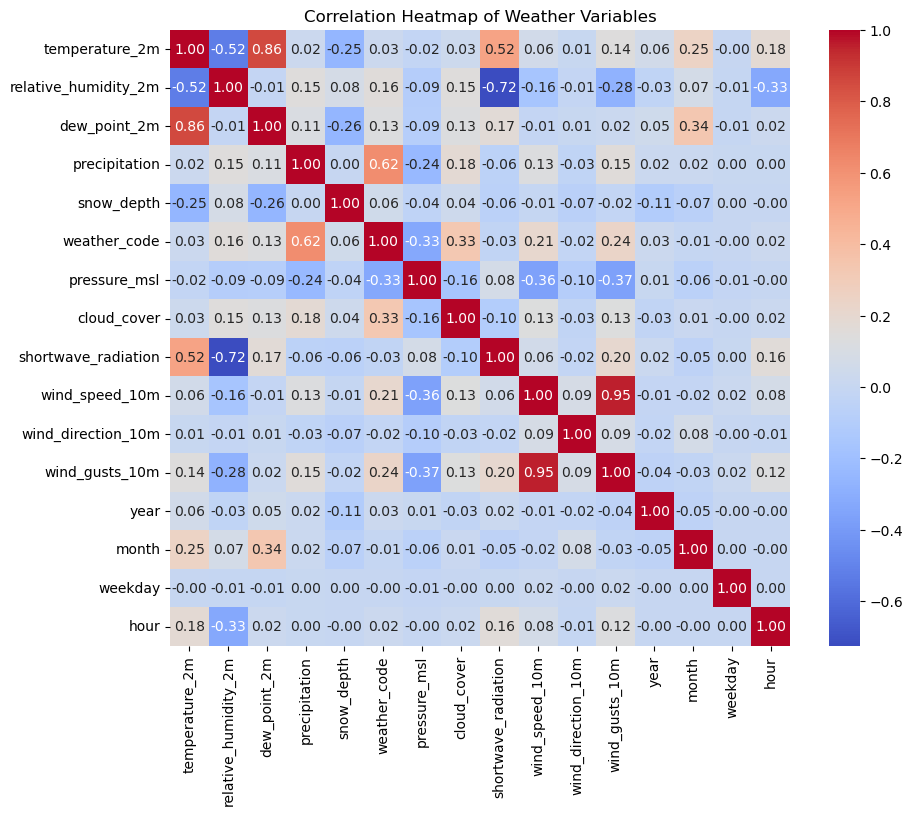

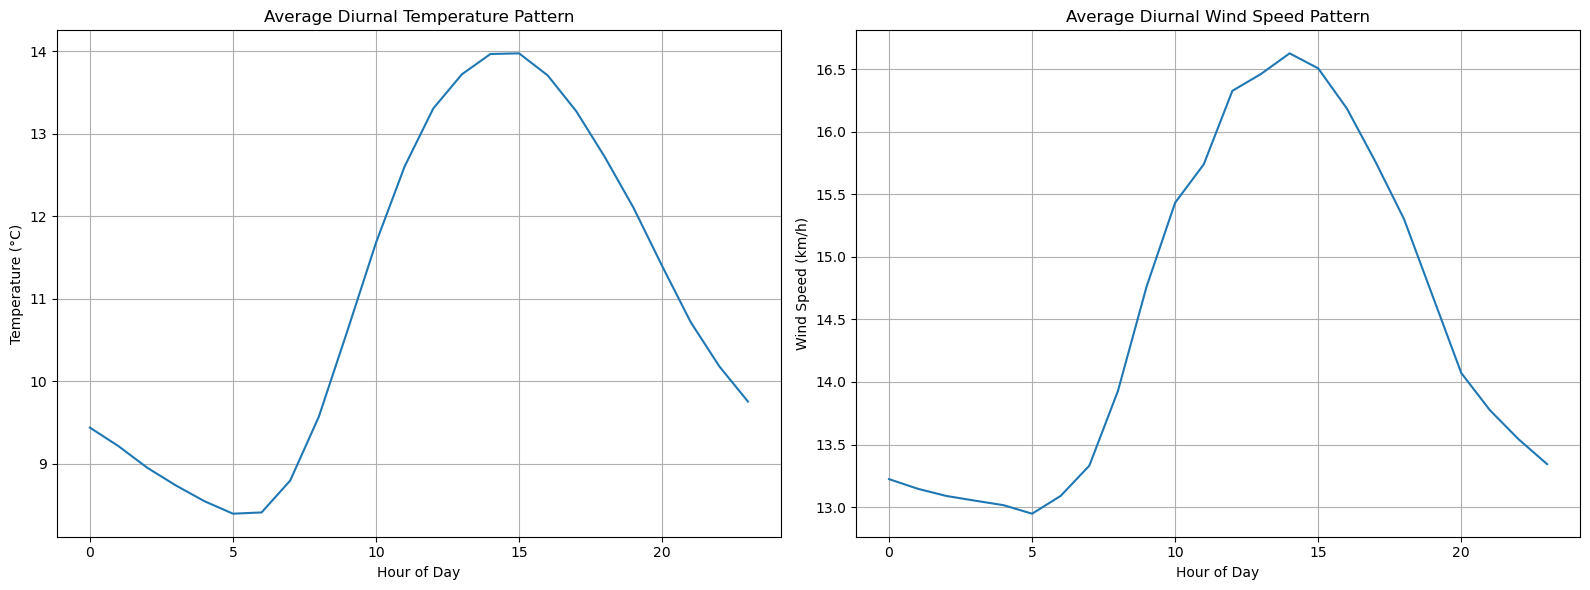


These charts show the average pattern of temperature and wind speed throughout the day.


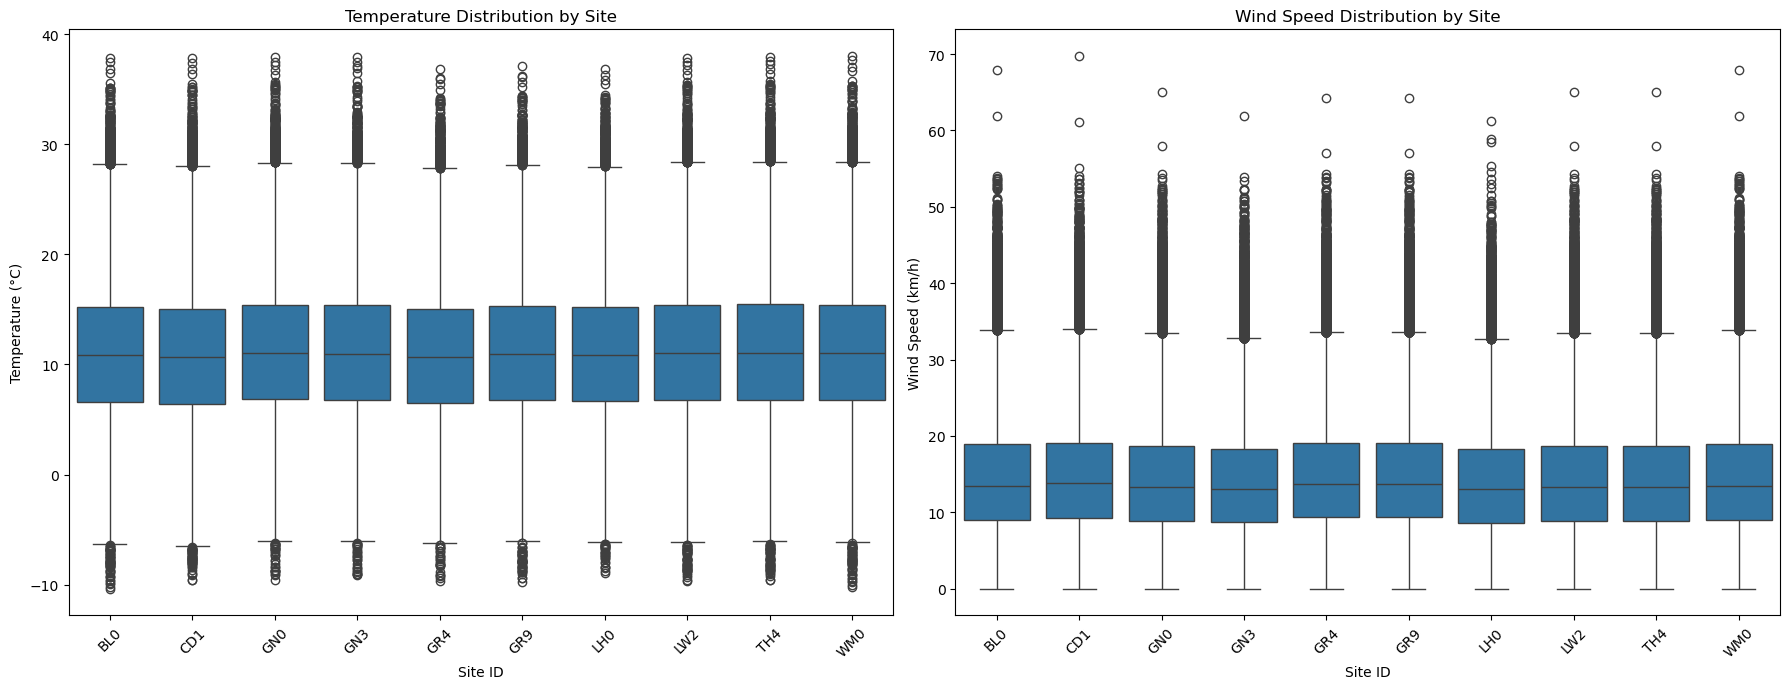


These boxplots help verify that the weather is broadly similar across all sites, as expected for one city.


In [12]:
# Plot 1: Correlation Heatmap of Weather Variables
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=np.number)
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Weather Variables')
plt.show()


# Plot 2: Diurnal (Daily) Patterns for Key Variables
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(data=df, x='hour', y='temperature_2m', ax=axes[0], errorbar=None)
axes[0].set_title('Average Diurnal Temperature Pattern')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(True)

sns.lineplot(data=df, x='hour', y='wind_speed_10m', ax=axes[1], errorbar=None)
axes[1].set_title('Average Diurnal Wind Speed Pattern')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Wind Speed (km/h)')
axes[1].grid(True)
plt.tight_layout()
plt.show()
print("\nThese charts show the average pattern of temperature and wind speed throughout the day.")



# Plot 4: Variation of Weather by Site
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.boxplot(data=df, x='siteid', y='temperature_2m', ax=axes[0])
axes[0].set_title('Temperature Distribution by Site')
axes[0].set_xlabel('Site ID')
axes[0].set_ylabel('Temperature (°C)')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df, x='siteid', y='wind_speed_10m', ax=axes[1])
axes[1].set_title('Wind Speed Distribution by Site')
axes[1].set_xlabel('Site ID')
axes[1].set_ylabel('Wind Speed (km/h)')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
print("\nThese boxplots help verify that the weather is broadly similar across all sites, as expected for one city.")